In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import re
import csv

# Load dataset 

In [2]:
dataset = {'train': {'question':[], 'intention':[]},
           'test': {'question':[]}}

with open('data/input_train.csv') as csvfile:
    index = 0
    reader = csv.reader(csvfile, delimiter=';', )
    reader.next()
    for row in reader:
        assert index == int(row[0]), '{} {}'.format(index, row[0])
        dataset['train']['question'].append(row[1])
        index += 1

with open('data/output_train.csv') as csvfile:
    index = 0
    reader = csv.reader(csvfile, delimiter=';', )
    reader.next()
    for row in reader:
        assert index == int(row[0]), '{} {}'.format(index, row[0])
        dataset['train']['intention'].append(row[1])
        index += 1

with open('data/input_test.csv') as csvfile:
    index = len(dataset['train']['question'])
    reader = csv.reader(csvfile, delimiter=';', )
    reader.next()
    for row in reader:
        assert index == int(row[0]), '{} {}'.format(index, row[0])
        dataset['test']['question'].append(row[1])
        index += 1

In [3]:
print pd.DataFrame(dataset['train']['intention'])
print pd.DataFrame(dataset['test']['question'])

       0
0     28
1     31
2     28
3     44
4     31
5     44
6     48
7     28
8     22
9     23
10    31
11    42
12    28
13    32
14    28
15    44
16    26
17     0
18    28
19    48
20    34
21    14
22     7
23    28
24    37
25    44
26    23
27    42
28     4
29    42
...   ..
7998  23
7999   4
8000  21
8001  44
8002  33
8003  28
8004  28
8005  14
8006   0
8007  31
8008  22
8009  48
8010  32
8011  22
8012  30
8013  22
8014  25
8015  44
8016  31
8017  29
8018  44
8019  22
8020  28
8021  28
8022  28
8023  41
8024  48
8025  42
8026  14
8027  22

[8028 rows x 1 columns]
                                                      0
0               autisme-homéopathie-antidote vaccins ??
1     Quel topique appliquer pour dermatite atopique...
2                      traitement kystes avec diane 35?
3     je souffre d'insuffisance veineuse (acrocyanos...
4     je suis enceinte depuis 1 mois, est ce que les...
5                                            triafémi ?
6     mon médecin m'a pro

### Explore class balancing

intent:  51


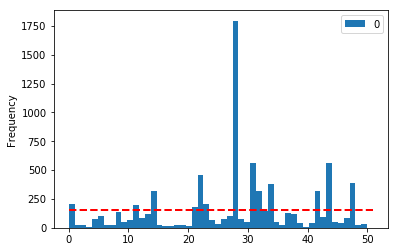

In [19]:
df = pd.DataFrame(dataset['train']['intention']).astype(float)
print 'intent: ', len(df[0].value_counts())

df.plot.hist(bins=51)
plt.plot([0, 51], [157, 157], 'r--', lw=2)
plt.show()

In [8]:
print pd.DataFrame(dataset['train']['intention'])[0].value_counts() / len(dataset['train']['intention'])

28    0.223717
31    0.070379
44    0.069756
22    0.057424
48    0.048206
34    0.047583
32    0.039985
14    0.039487
42    0.039238
23    0.025909
0     0.025411
11    0.024290
21    0.022422
33    0.017937
8     0.016692
37    0.015695
38    0.014948
13    0.014823
27    0.012955
5     0.012706
43    0.011335
12    0.011086
47    0.010214
29    0.009591
4     0.009467
26    0.008969
10    0.008470
24    0.007972
9     0.006726
30    0.006477
45    0.006228
35    0.006228
41    0.005605
46    0.005605
39    0.004983
50    0.004111
25    0.003737
6     0.003239
36    0.003114
15    0.002865
18    0.002865
1     0.002865
2     0.002740
49    0.002740
7     0.002491
19    0.002491
20    0.002367
16    0.002118
17    0.001868
3     0.000997
40    0.000872
Name: 0, dtype: float64


# Load RCP and components dataset

In [ ]:
rcp = {}
components = {}
with open('data/CIS.txt') as textfile:
    lines = map(lambda l: l.strip('\r\n').split('\t'), textfile.readlines())
    for line in lines:
        code_cis, name = int(line[0]), line[1]
        rcp[code_cis] = {
            'name': name,
            'commercialization': line[-3] == 'Commercialis\xe9e',
            'composition': []
        }

with open('data/COMPO.txt') as textfile:
    lines = map(lambda l: l.strip('\r\n').split('\t'), textfile.readlines())
    for line in lines:
        code_cis, code_compo, name, type = int(line[0]), int(line[2]), line[3], line[1]
        rcp[code_cis]['composition'].append(code_compo)
        components[code_compo] = {
            'name': name,
            'type': type
        }

### Clean names to only keep drug name

In [ ]:
subre = '&|mg|ml|mL|POUR CENT|POUR MILLE|h|heures|g|\%|UI|U.I.|SANS SUCRE|microgrammes|I.V.|dose|ENFANTS|IM|IR|ENFANTS ET NOURRISSONS|ADULTES|U.CEIP'
for cis_code in rcp:
    #print rcp[cis_code]['name']
    rcp[cis_code]['clean_name'] = rcp[cis_code]['name'].split(' ')[0].strip(' ,')
    #print rcp[cis_code]['clean_name']
    '''
    match = re.match(r"(([A-Z.\/ \(\)\-])+)([0-9,. \/]*("+ subre +")[\/]*)*, .*", rcp[cis_code]['name'])
    if match:
        rcp[cis_code]['clean_name'] = match.group(1).split(' ')[0].strip(' ')
        #print rcp[cis_code]['clean_name']
    else:
        #print rcp[cis_code]['name']
        pass
    '''

In [ ]:
print rcp[69133501]

# Extract and clean sentences

In [ ]:
import ftfy
import spacy
import pickle as pkl
from textacy import preprocess_text

nlp = spacy.load('fr')

In [ ]:
def create_corpus(split):
    for idx in range(len(dataset[split]['question'])):
        if idx+1 > 20:
            pass
        if (idx+1) % 100 == 0:
            print '{} out of {}'.format(idx+1, len(dataset[split]['question']))

        # Preprocess question
        question = dataset[split]['question'][idx]
        question = preprocess_text(question.decode('utf-8'), fix_unicode=True, no_accents=True, lowercase=True)
        tokens = [token.lower_ for token in nlp(question)]
        
        # Extract intention
        if dataset[split].has_key('intention'):
            corpus[split]['labels'].append(dataset[split]['intention'][idx])
            
        # Update corpus with processed texts
        corpus[split]['raw_texts'].append(question)
        
        med_idx = 0
        for cis_code in rcp:
            if rcp[cis_code].has_key('clean_name') and rcp[cis_code]['commercialization']:
                if len(rcp[cis_code]['clean_name']) <= 4:
                    continue

                _, encoding = ftfy.guess_bytes(rcp[cis_code]['clean_name'])
                cis_name = preprocess_text(rcp[cis_code]['clean_name'].decode(encoding),
                                           fix_unicode=True, no_accents=True, lowercase=True)

                if cis_name in tokens:
                    question = question.replace(cis_name, 'MED{}'.format(med_idx))
                    tokens.remove(cis_name)
                    med_idx += 1
        
        #print dataset[split]['question'][idx]
        #print question

        corpus[split]['texts_with_numbered_med'].append(question)
        corpus[split]['texts_with_med'].append(re.sub(r'MED[0-9]', u'MED', question))

In [ ]:
corpus = {
    'train':{
        'labels': [],
        'raw_texts': [],
        'texts_with_med': [],
        'texts_with_numbered_med': []
    },
    'test':{
        'labels': [],
        'raw_texts': [],
        'texts_with_med': [],
        'texts_with_numbered_med': []
    },
    'rcp': rcp,
    'components': components
}
print 'Test'
create_corpus('test')

In [ ]:
print 'Train'
create_corpus('train')

In [ ]:
pkl.dump(corpus, open('data/corpus.pkl', 'w'))